## Credits
Steam - https://store.steampowered.com/search/?category1=998

### _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _

## Download packages

In [1]:
#pip install selenium

In [2]:
#conda install -c conda-forge imbalanced-learn

## Imports

In [3]:
from time import sleep
from bs4 import BeautifulSoup
from selenium import webdriver
import pandas as pd
import numpy as np
import random
import re
from datetime import datetime
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn import linear_model, metrics, preprocessing
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
from sklearn.model_selection import GridSearchCV

# show several prints in one cell. This will allow us to condence every trick in one cell.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _

## Save and load data from CSV

#### Save to csv

Save to CSV file

In [4]:
def save_to_csv(file_name, dataset):
    dataset.to_csv(file_name)

Save data before cleanup

In [5]:
# save_to_csv("all_games_data.csv", df)

Save data after cleanup

In [6]:
# save_to_csv("all_games_data_clean.csv", new_df)

#### Load from csv

Load dataset from CSV

In [7]:
def load_csv_from_project(file_name):
    return pd.read_csv(file_name)

Load data before cleanup

In [8]:
df = load_csv_from_project("all_games_data.csv").iloc[:,1:]

Load data after cleanup

In [117]:
new_df = load_csv_from_project("all_games_data_clean.csv").iloc[:,1:]

In [120]:
new_df.head()

,title,win_support,mac_support,linux_support,vr_only,vr_supported,discount,price_discount,price,overall_review,percentage_positive_total_reviewed,total_reviewed,day,month,year
0,Counter-Strike: Global Offensive,1,1,1,0,0,0,0.0,0.0,Very Positive,88,6357070,21,8,2012
1,Apex Legends™,1,0,0,0,0,0,0.0,0.0,Very Positive,86,436849,4,11,2020
2,ELDEN RING,1,0,0,0,0,0,249.0,249.0,Very Positive,89,340296,24,2,2022
3,LEGO® Star Wars™: The Skywalker Saga,1,0,0,0,0,0,199.0,199.0,Very Positive,94,15740,5,4,2022
4,PUBG: BATTLEGROUNDS,1,0,0,0,0,0,0.0,0.0,Mixed,56,2005741,21,12,2017


### _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _

## Helper Functions

In [10]:
def write_soup_to_file(file_name : str, soup : BeautifulSoup):
    with open(file_name, "w", encoding='utf-8') as file:
        file.write(str(soup))

In [11]:
def load_soup_object(html_file_name : str):
    with open(html_file_name, "r", encoding='utf8') as file:
        soup = BeautifulSoup(file, "html.parser")
    return soup

In [12]:
def isfloat(num):
    try:
        float(num)
        return True
    except ValueError:
        return False

In [13]:
def isint(num):
    try:
        int(num)
        return True
    except ValueError:
        return False

### _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _

## Crawling With Selenium & BeautifulSoup

In [14]:
def get_driver_Firefox():
    return webdriver.Firefox()  

In [15]:
def infinite_scroll(driver : webdriver.firefox.webdriver.WebDriver):
    
    _isScrolling = True
    SCROLL_PAUSE_TIME = 0.8
    
    # Get scroll height
    last_height = driver.execute_script("return document.body.scrollHeight")
    
    while _isScrolling:
                
        # Scroll down to bottom
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    
        # Wait to load page
        sleep(SCROLL_PAUSE_TIME)
        SCROLL_PAUSE_TIME = random.uniform(0.8,3)
        
        # Calculate new scroll height and compare with last scroll height
        new_height = driver.execute_script("return document.body.scrollHeight")
                
        if new_height == last_height:
            #Another check
            sleep(20)
            new_height = driver.execute_script("return document.body.scrollHeight")
            
            if new_height == last_height:            
                _isScrolling = False
                                
        last_height = new_height

In [16]:
def selenium_scrapping():
    url = "https://store.steampowered.com/search/?category1=998"
    driver = get_driver_Firefox()
    
    driver.get(url)
    driver.maximize_window()
    
    # Wait for the page to fully render before parsing it
    sleep(5)
    
    infinite_scroll(driver)
    
    print("Finish scroling... initialize BeautifulSoup")
    
    soup = BeautifulSoup(driver.page_source, "html.parser")
    
    #quits the driver instance, closing every associated window, which is opened.
    driver.quit()
    
#selenium_scrapping()

#### Save BeautifulSoup to HTML

In [17]:
#write_soup_to_file("All_Games.html", soup)

#### Load BeautifulSoup from HTML

In [18]:
#soup = load_soup_object("All_Games.html")

### _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _

## Data Acquisition

In [19]:
def game_tag_exist(game , tag : str, classTag : str):
    if game.find(tag, attrs={"class",classTag}):
        return 1
    return 0

In [20]:
def game_get_text_tag(game, tag :str , classTag : str):
    return game.find(tag, attrs={"class", classTag}).get_text().strip()

In [21]:
def game_val_tag(game, tag :str , classTag : str):
    if game_tag_exist(game, tag, classTag):
        val = game_get_text_tag(game, tag, classTag)
        return np.nan if val == '' else val
        
    return np.nan

In [22]:
def game_prices(game, tag :str , classTag : str):
    prices = [np.nan]
    price_text = game_val_tag(game, "div", "search_price")
    if price_text is not np.nan:        
        if '₪' in price_text:
            prices = price_text.split('₪')
            prices.pop(0)
            if isfloat(prices[0]) is False:
                # price with ',' like 1,850.00
                if ',' in prices[0] :
                    prices[0] = float(prices[0].replace(',', ''))
                #Price like 49.00Free and discount 70% - is not relevent (only 2 like this)
                else:
                    prices = [np.nan]
            else:
                prices = [float(i) for i in prices]
        else:
            #free games
            prices = [float(0)]
            
    return prices
        

In [23]:
def scrape_games(soup : BeautifulSoup):
    game_title = list()
    game_win_support = list()
    game_mac_support = list()
    game_linux_support = list()    
    game_vr_only = list()
    game_vr_supported = list()
    game_relese_date = list()
    game_review = list()
    game_discount = list()
    game_price_discount = list()
    game_price = list()    
    
    all_games = soup("a",attrs={"class":"search_result_row"})    
    for game in all_games:
        game_title.append(game_val_tag(game, 'span', 'title'))
        game_win_support.append(game_tag_exist(game,'span', "win"))
        game_mac_support.append(game_tag_exist(game,'span', "mac"))
        game_linux_support.append(game_tag_exist(game,'span', "linux"))
        game_vr_only.append(game_tag_exist(game,'span', "vr_required"))
        game_vr_supported.append(game_tag_exist(game,'span', "vr_supported"))
        game_relese_date.append(game_val_tag(game, "div", "search_released"))
        game_review.append(game.find("span", attrs={"class",'search_review_summary'})['data-tooltip-html'] if game_tag_exist(game,'span', "search_review_summary") else np.nan)
        game_discount.append(game_val_tag(game, "div", "search_discount"))
        
        prices = game_prices(game, "div", "search_price")       
        game_price.append(prices[0])
        game_price_discount.append(prices[0] if len(prices) == 1 else prices[1])
         
    return pd.DataFrame({"title":game_title, "win_support":game_win_support
                         , "mac_support":game_mac_support, "linux_support":game_linux_support,
                         "vr_only":game_vr_only, "vr_supported":game_vr_supported,
                           "relese_date": game_relese_date, "review":game_review,
                         "discount":game_discount , "price_discount":game_price_discount ,"price":game_price })

In [24]:
# We are loading our data from csv in order to avoid rerunning the scraper every time
#df = scrape_games(soup)

### _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _

## Data Cleaning

#### Handle Missing Values

Drop missing values

In [25]:
def drop_missing_values(df : pd.DataFrame, columns :list):
    df_copy = df.copy()
    df_copy.dropna(subset=columns, inplace = True)
    return df_copy

Fill missing values

In [26]:
def fill_na_values(df : pd.DataFrame, col:str, val):
    df_copy = df.copy()
    df_copy[col].fillna(val, inplace = True)
    return df_copy

#### discount

In [27]:
def discount_clean(df : pd.DataFrame):
    df_copy = df.copy()
    df_copy['discount'] = [int(re.sub("[-%]" ,"", str(discount))) for discount in df_copy['discount']]
    return df_copy

#### review

In [28]:
def review_clean(df : pd.DataFrame):
    df_copy = df.copy()
    
    overall_review = list()
    percentage_positive_total_reviewed = list()
    total_reviewed = list()
    
    for rev in df_copy['review']:
        #For removing if else
        splited_data = ['no reviews','0 0 0 0']
        if rev is not np.nan:
            splited_data = rev.split('<br>')    
                
        reviewers = splited_data[1].split(' ')            
        overall_review.append(splited_data[0])        
        percentage_positive_total_reviewed.append(int(reviewers[0].replace('%','')))
        total_reviewed.append(int(reviewers[3].replace(',','')))
        
    df_copy['overall_review'] = overall_review
    df_copy['percentage_positive_total_reviewed'] = percentage_positive_total_reviewed
    df_copy['total_reviewed'] = total_reviewed
    
    df_copy.drop(['review'], axis = 1, inplace=True)
    
    return df_copy

#### relese_date

In [29]:
def relese_date_clean(df : pd.DataFrame):
    df_copy = df.copy()
    
    day = list()
    month = list()
    year = list()
    rows_to_remove = list()
    
    for idx in df_copy.relese_date.index.values:
        date_splited = df_copy.relese_date[idx].split(' ') 
        if len(date_splited) == 3 and isint(date_splited[0]):
            final_date = datetime.strptime(df_copy.relese_date[idx].replace(',',''), '%d %b %Y').strftime('%d %m %Y')
            date_splited = final_date.split(' ')
            day.append(date_splited[0])
            month.append(date_splited[1])
            year.append(date_splited[2])
        else:
            rows_to_remove.append(idx)
            
    df_copy.drop(index=rows_to_remove, inplace=True)
    df_copy.drop(['relese_date'], axis = 1, inplace=True)
    df_copy['day'] = list(map(int, day))
    df_copy['month'] = list(map(int, month))
    df_copy['year'] = list(map(int, year))
    
    return df_copy

#### Cleaning Data

In [30]:
cols_with_missing_values = ['price','relese_date','title']
new_df = drop_missing_values(df, cols_with_missing_values)
new_df = fill_na_values(new_df, 'discount', 0)
new_df = discount_clean(new_df)
new_df = review_clean(new_df)
new_df = relese_date_clean(new_df)

### _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _

##  Data Handling

#### Helper functions

get_frequenft_elements returns the value count of the elements in the received column name.

In [31]:
def get_frequenft_elements(df, col_name):
    return df[col_name].value_counts().sort_index()

amount_of_discounts will provide as a series with the amount of games with a discount and the amount of games without.

In [32]:
def amount_of_discounts(df):
    no_discound_sum = (df['discount'] == 0).sum()    
    with_discound_sum = (df['discount'] != 0).sum()

    return pd.Series(data={'no discount': no_discound_sum, 'has discount': with_discound_sum})

Let's add a new categorial column that will represent whether the game has a discount or not.
It will hold 0 for games without discount and 1 otherwise.

In [33]:
def add_has_discount_col(df):
    
    edited_df = df.copy()
    has_discount = list()
    
    for idx in edited_df.discount.index.values:
        if edited_df.discount[idx] != 0:
            has_discount.append(1)
        else:
            has_discount.append(0)
    
    edited_df['has_discount'] = has_discount
    
    return edited_df

#### Deep Investigation

We would like to get a dipper understanding about our data.

First, we will check if our data is balanced. 
We would like to make sure that we have a wide and balanced cut in the game types.

We would like to axamin: 
1. Overall review value
2. Release year
3. Amount of games with and without discount
4. Price

### 1. overall_review

In [34]:
def pie_chart_overall_review(df, fig, axes, title, show_data):

    sr_freq_directors = get_frequenft_elements(new_df, 'overall_review')
    
    if show_data:
        print (sr_freq_directors)

    mylabels = ["Overwhelmingly Positive", "Very Positive", "Positive", "Mostly Positive", "Mixed", "Mostly Negative", "Negative", "Very Negative", "Overwhelmingly Negative", "no reviews"]
    mycolors = ["#0ae000",                 "#8dec48",       "#aefc50",  "#c1fe1f",        "#f5fc0f", "#fcd40f",        "#fca60f",  "#fc6c0f",       "#fc0f0f",                 "#a4dcd5"]

    sr_freq_directors.plot(kind='pie', ax=axes, title=title, ylabel="review")
    #sr_freq_directors.plot(kind='pie', ax=axes, labels = mylabels, colors = mycolors)

Mixed                       7749
Mostly Negative             1088
Mostly Positive             5536
Negative                     173
Overwhelmingly Negative        6
Overwhelmingly Positive      853
Positive                    6657
Very Negative                 25
Very Positive               9046
no reviews                 20312
Name: overall_review, dtype: int64


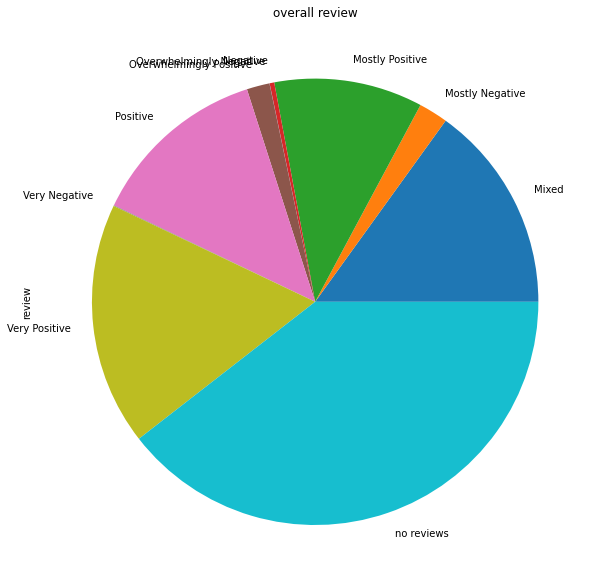

In [35]:
fig, axes = plt.subplots(1,1, figsize=(10, 40))

pie_chart_overall_review(new_df, fig, axes, "overall review", True)

According to Steam review rating system - The classification by positive precantage:

    95 - 99% : Overhwelmingly Positive
    94 - 80% : Very Positive
    80 - 99% + few reviews: Positive
    70 - 79% : Mostly Positive
    40 - 69% : Mixed
    20 - 39% : Mostly Negative
    0 - 39% + rew reviews: Negative
    0 - 19% : Very Negative
    0 - 19% + many reviews: Overwhelmingly Negative
    
Most of our games are rated as positive and higher as expected form a games store like Steam.

### 2. Release year

In [36]:
def pie_chart_release_year_investigation(df, fig, axes, title, show_data):

    sr_freq_directors = get_frequenft_elements(df, 'year')
    
    if show_data:
        print (title)
        print (sr_freq_directors)

    sr_freq_directors.plot(kind='pie', ax=axes, ylabel="year", title=title)

release year
1997        1
1998        1
1999        2
2000        2
2001        2
2002        1
2003        2
2004        6
2005        2
2006       54
2007       86
2008      113
2009      304
2010      244
2011      254
2012      336
2013      435
2014     1383
2015     2164
2016     3538
2017     5314
2018     7138
2019     7165
2020     8745
2021    10668
2022     3455
2023       15
2024        6
2026        3
2030        4
2033        1
2041        1
Name: year, dtype: int64


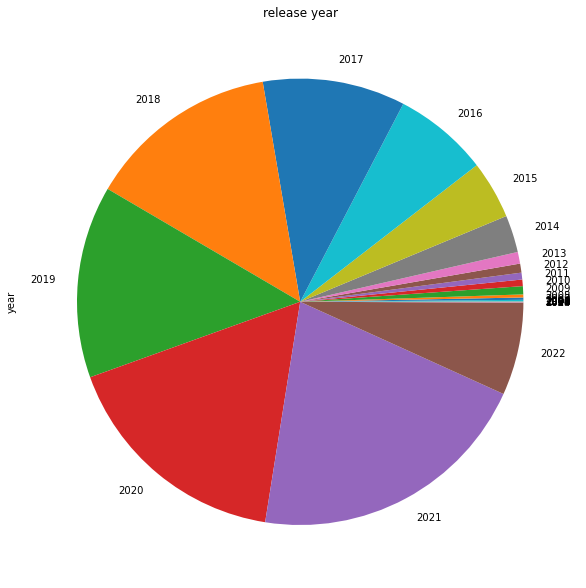

In [37]:
fig, axes = plt.subplots(1,1, figsize=(10, 40))

pie_chart_release_year_investigation(new_df, fig, axes, "release year", True)

We were positivly impressed by this graph. It shows a pretty big variaty of release years.
We assumed that most of the games offered for sale will be from the last few years but we were impressed that there is a generouse amount of games from over 4 years ago.

But, we also noticed some outliers we should handle.
Release date shouln't be above 2022 since we are in 2022. Also, we would like to igonre data from 2005 and below since it is might not be relevant anymore.

##### Remove Release Year Outliers

C:\Users\maypo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='year'>

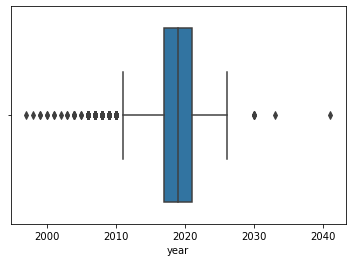

In [38]:
sns.boxplot(new_df.year)

In [39]:
def drop_year_outliers(df, min_year):
    df_centered = df.drop(df[df.year > 2022].index).copy()
    df_centered = df_centered.drop(df_centered[df_centered.year <= min_year].index) 
    return df_centered

C:\Users\maypo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='year'>

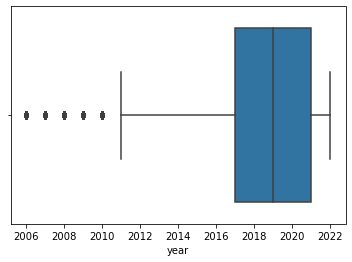

In [40]:
df_no_outliers = drop_year_outliers(new_df, 2005)

sns.boxplot(df_no_outliers.year)

Better. Now after removing some of the data, we can re-investigate the release year data.

Let's try to drop rows from 2013 and below.

C:\Users\maypo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='year'>

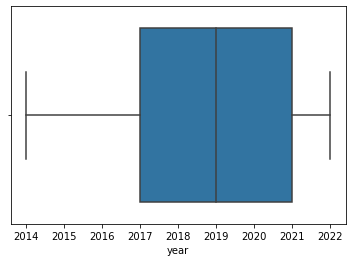

In [41]:
df_no_outliers = drop_year_outliers(new_df, 2013)

sns.boxplot(df_no_outliers.year)

Looks like there aren't any outliers.
Let's compare the changes:

include outliers
1997        1
1998        1
1999        2
2000        2
2001        2
2002        1
2003        2
2004        6
2005        2
2006       54
2007       86
2008      113
2009      304
2010      244
2011      254
2012      336
2013      435
2014     1383
2015     2164
2016     3538
2017     5314
2018     7138
2019     7165
2020     8745
2021    10668
2022     3455
2023       15
2024        6
2026        3
2030        4
2033        1
2041        1
Name: year, dtype: int64
---
without outliers
2014     1383
2015     2164
2016     3538
2017     5314
2018     7138
2019     7165
2020     8745
2021    10668
2022     3455
Name: year, dtype: int64


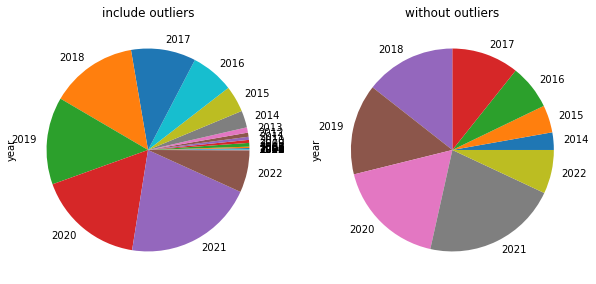

In [42]:
fig, axes = plt.subplots(1,2, figsize=(10, 40))

pie_chart_release_year_investigation(new_df, fig, axes[0], "include outliers", True)
print("---")
pie_chart_release_year_investigation(df_no_outliers, fig, axes[1], "without outliers", True)

Looks like our data is much cleaner now

In [43]:
new_df = df_no_outliers

### 3. Amount of games with and without discount

First, we will create a new column that will indecates whether the game is on sale or not.

In [44]:
def pie_chart_discount_investigation(df, fig, axes, title, show_data):

    sr_freq_directors = amount_of_discounts(df)
    
    if show_data:
        print (title)
        print (sr_freq_directors)

    sr_freq_directors.plot(kind='pie', ax=axes, ylabel="discount", title=title)

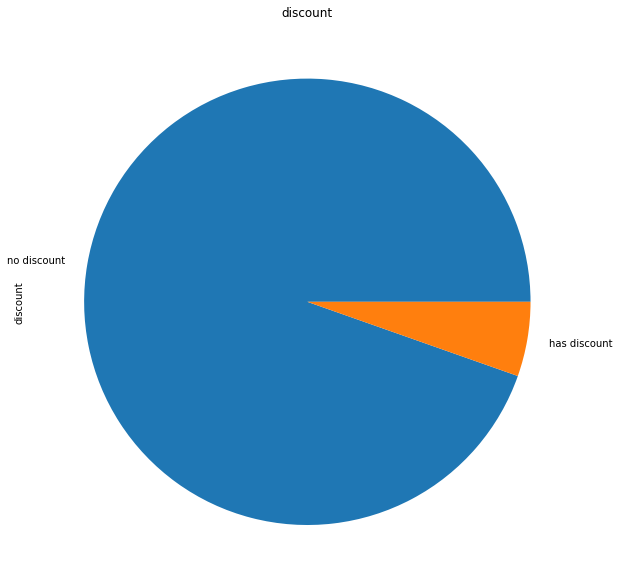

In [45]:
fig, axes = plt.subplots(1,1, figsize=(10, 40))

pie_chart_discount_investigation(new_df, fig, axes, "discount", False)

After analyzing this graph we can understand that our data needs to be a bit more balanced.
The amount of data for games without discount is much higher then the amount of games with discount.
We will have to adjust our data and balance it by duplicating the games data with discount and present Oversampling.

##### Oversampling
Randomly duplicate examples in the minority class

In [46]:
def preform_oversampling_has_discount(df):
    
    edited_df = add_has_discount_col(df)
    
    oversample = RandomOverSampler(sampling_strategy=0.5)
    oversample_df, oversample_has_discount = oversample.fit_resample(edited_df, edited_df['has_discount'])
    
    return oversample_df

In [47]:
oversample_df = preform_oversampling_has_discount(new_df)

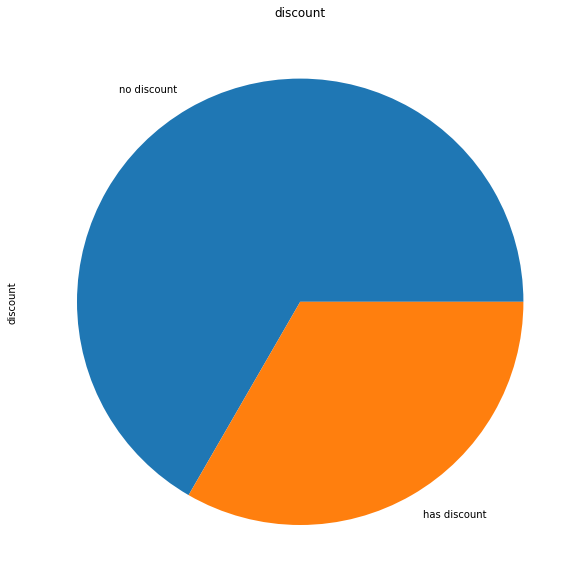

In [48]:
fig, axes = plt.subplots(1,1, figsize=(10, 40))

pie_chart_discount_investigation(oversample_df, fig, axes, "discount", False)

Looks much better. Seems like our data is balanced now

By comparing both pie charts before and after oversampling we can witness the improvment:

before oversampling
no discount     46896
has discount     2674
dtype: int64
after oversampling
no discount     46896
has discount    23448
dtype: int64


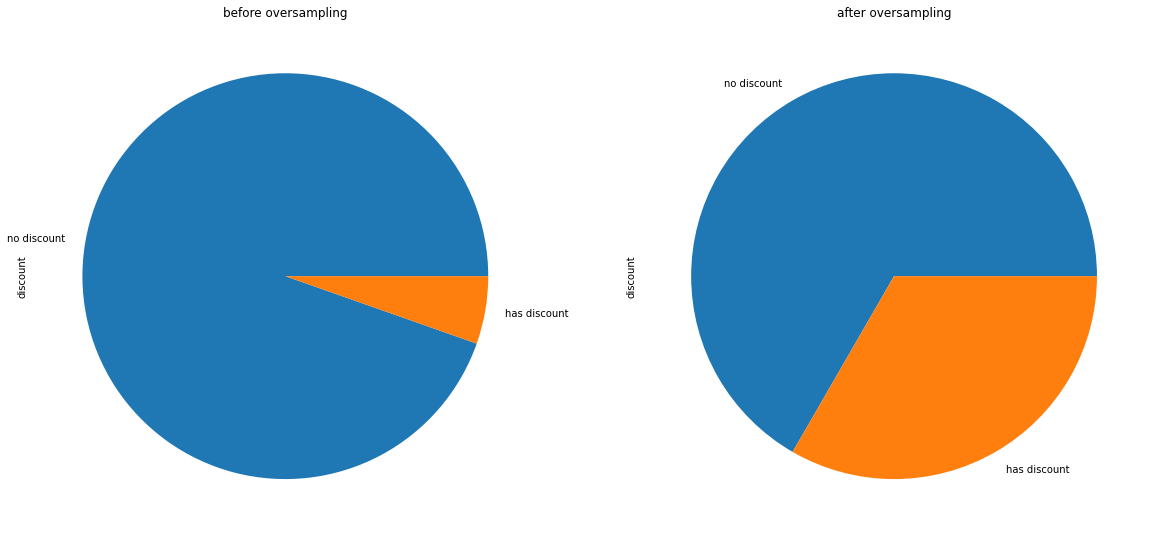

In [49]:
fig, axes = plt.subplots(1,2, figsize=(20, 30))

pie_chart_discount_investigation(new_df, fig, axes[0], "before oversampling", True)
pie_chart_discount_investigation(oversample_df, fig, axes[1], "after oversampling", True)

In [50]:
# update our dataset with the balanced data
new_df = oversample_df

### 4. Price

In [51]:
def pie_chart_price_investigation(df, fig, axes, title, show_data):

    sr_freq_directors = get_frequenft_elements(df, 'price')
    
    if show_data:
        print (title)
        print (sr_freq_directors)

    sr_freq_directors.plot(kind='pie', ax=axes, ylabel="price", title=title)

overall review
0.00       6685
3.15         17
3.16          1
3.20         12
3.24          1
           ... 
449.95        3
564.95        1
749.95       22
1450.00       1
1850.00       1
Name: price, Length: 554, dtype: int64


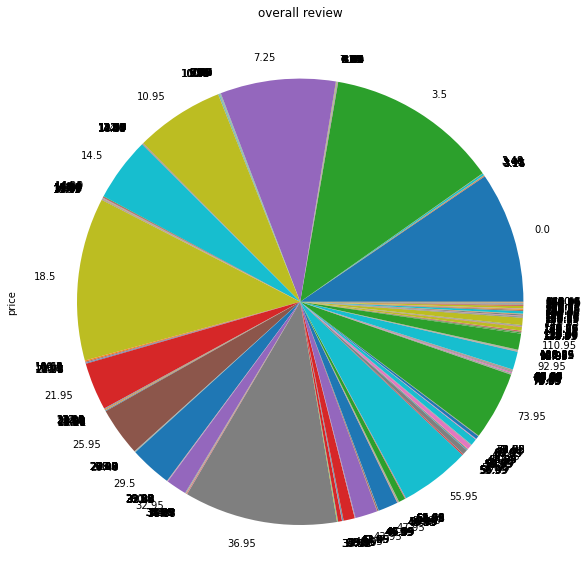

In [52]:
fig, axes = plt.subplots(1,1, figsize=(10, 40))

pie_chart_price_investigation(new_df, fig, axes, "overall review", True)

Let's check if we have any outliers:

C:\Users\maypo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='price'>

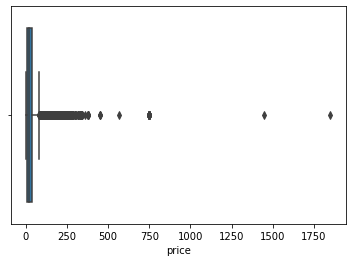

In [53]:
sns.boxplot(new_df.price)

##### Remove Price Outliers

In [54]:
def drop_price_outliers(df, max_price):
    df_centered = df.drop(df[df.price > max_price].index).copy()
    return df_centered

C:\Users\maypo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='price'>

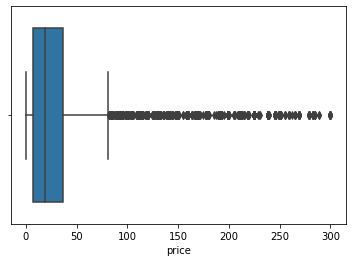

In [55]:
df_no_price_outliers = drop_price_outliers(new_df, 300)

sns.boxplot(df_no_price_outliers.price)

We decieded that this is a good cut for our data. 
We would like to train our model with games that costs 300₪ and less

Price with outlier
0.00       6685
3.15         17
3.16          1
3.20         12
3.24          1
           ... 
449.95        3
564.95        1
749.95       22
1450.00       1
1850.00       1
Name: price, Length: 554, dtype: int64
Price without outlier
0.00      6685
3.15        17
3.16         1
3.20        12
3.24         1
          ... 
279.00      10
283.00      14
284.95       2
289.00       2
299.95      12
Name: price, Length: 541, dtype: int64


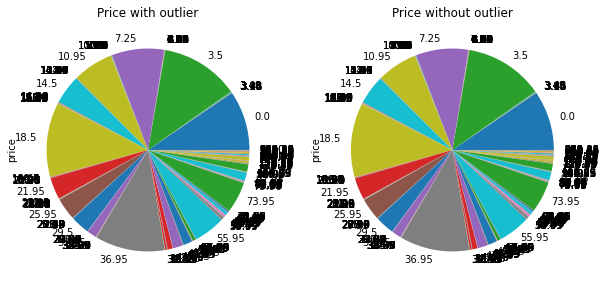

In [56]:
fig, axes = plt.subplots(1,2, figsize=(10, 40))

pie_chart_price_investigation(new_df, fig, axes[0], "Price with outlier", True)
pie_chart_price_investigation(df_no_price_outliers, fig, axes[1], "Price without outlier", True)

In [57]:
# update our dataset with the balanced data
new_df = df_no_price_outliers

Now we can see clearly that our data is balanced and ready for investigation

In [58]:
def drop_support_column(df, col_name):
    return df.drop(col_name, axis = 1).copy()

In [59]:
# we are no long need the has_discount column we can remove it
# new_df = drop_support_column(oversample_df, "has_discount")

We've finished our data handling. We've handled outliers and unbalanced our data.

Final results:

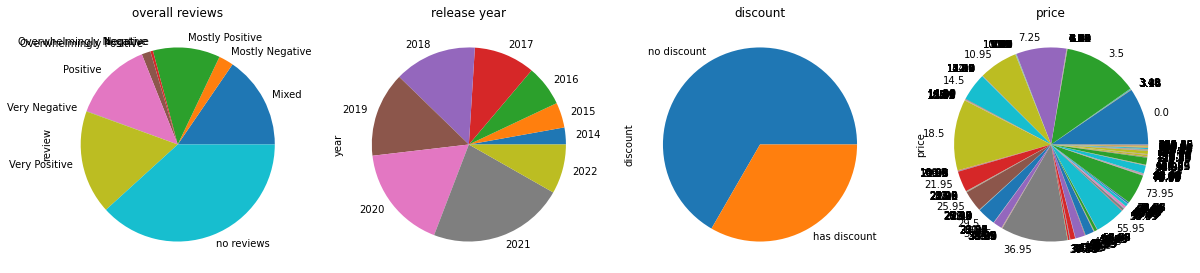

In [60]:
fig, axes = plt.subplots(1,4, figsize=(20, 30))

pie_chart_overall_review(new_df, fig, axes[0], "overall reviews", False)
pie_chart_release_year_investigation(new_df, fig, axes[1], "release year", False)
pie_chart_discount_investigation(new_df, fig, axes[2], "discount", False)
pie_chart_price_investigation(new_df, fig, axes[3], "price", False)

Let's check what is our state. We lost and added data during the data handling.

In [61]:
print(new_df.shape)

(70277, 16)


### _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _

## EDA

##### Helper functions

cross_tabulation function is a function to create and return a datadrame of a cross tabulation between the given 'col_name' column and the given 'other_col_name' column

In [62]:
def cross_tabulation(df, col_name, other_col_name, normalize_val = "index"):
    return pd.crosstab(df[col_name], df[other_col_name], normalize=normalize_val)

'plot_cross_tabulation' function to create a cross tabulation for each of the columns in the given 'col_names' with the other given 'other_col_name' column.
The function plot a 'line' plot for each dataframe of the cross tabulation.

In [63]:
def plot_cross_tabulation(df, col_names, other_col_name, kind_val):
    fig, axes = plt.subplots(1,len(col_names), figsize=(20,5))
    i = 0
    for col in col_names:
        crosstb = cross_tabulation(df, col, other_col_name)
        crosstb.plot(kind=kind_val, ax=axes[i])
        i = i + 1

'get_highly_correlated_cols' function to return two arrays:
* 'correlations'
    - An python list, containing the correlation values for highly correlated columns from the given 'df' dataframe.
* 'tuple_arr'  
    - A python list, containing two dimensional tuples, representing two columns with a high correlation.
        * Two columns are considered as correlated if the value of the Pearson correlation coefficient of these columns is >=0.5. 
        * Each tuple should look like this: (i, j), where 'i' and 'j' are number of the highly correlated columns.
        * Remember that for two columns x, y, the correlation(x,y) =  correlation(y,x).
        * Only one corresponding pair should be returned. 
        * You should make sure that i < j. For instance, if columns 3 and 5 are correlated, return the tuple (3, 5) instead of (5, 3).
        * Don't forget to filter self correlation (of a column with the same column).

In [64]:
def get_highly_correlated_cols(df):
    tuple_arr = []
    correlations = []
                    
    discount_idx = df.columns.get_loc('discount') 
    for col in df.columns:
        col_idx = df.columns.get_loc(col)
        if col != 'discount' and col != 'has_discount' and col != 'price_discount':
            corr = df[col].corr(df['discount'], method='pearson')
            if abs(corr) >= 0.03:
                print (corr)
                tup = (col_idx, discount_idx)
                tuple_arr.append(tup)
                correlations.append(corr)
            
    
    return correlations, tuple_arr

'plot_high_correlated_scatters' function to plot scatter plots for each column pair, of the given 'df' dataframe, which has a high Pearson correlation coefficient (>=0.5). 
Uses the 'get_highly_correlated_cols', which you've already implemented, to get the highly correlated column pair numbers.

In [65]:
def plot_high_correlated_scatters(df):    
    i = 0
    correlations, tuple_arr = get_highly_correlated_cols(df)
    
    fig, axes = plt.subplots(1,len(correlations), figsize=(20,5))
    for pair in tuple_arr:
        col_name_lt, col_name_rt = df.columns[pair[0]], df.columns[pair[1]]
        title = "corr('%s', '%s')=%4.2f" %(col_name_lt, col_name_rt, correlations[i]) 
        df.plot(col_name_lt, col_name_rt, kind="scatter", ax=axes[i], title = title)
        i = i + 1

#### Correlation between two categorial variables

Let's check if there is a connection between the release year and overall review with whether the game has a discount or not

for displaying correlation between categorial columns we used cross tabulation

##### line graph

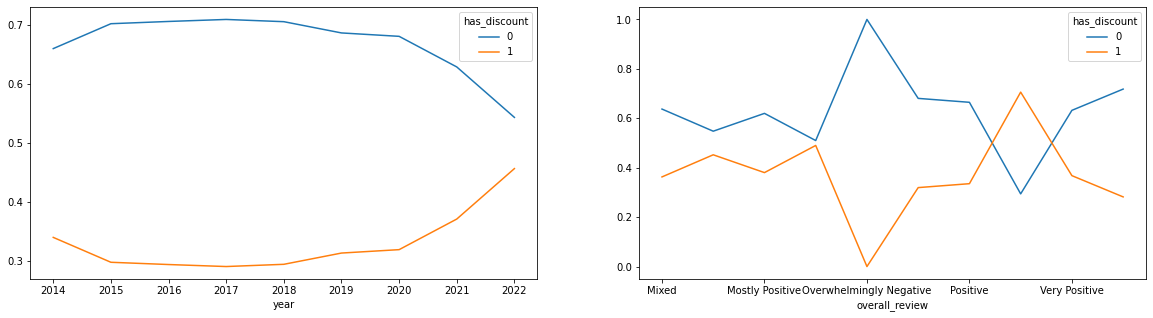

In [66]:
plot_cross_tabulation(new_df, ['year', 'overall_review'], 'has_discount', 'line')

We can also see the results using bar graphs:

##### bar graph

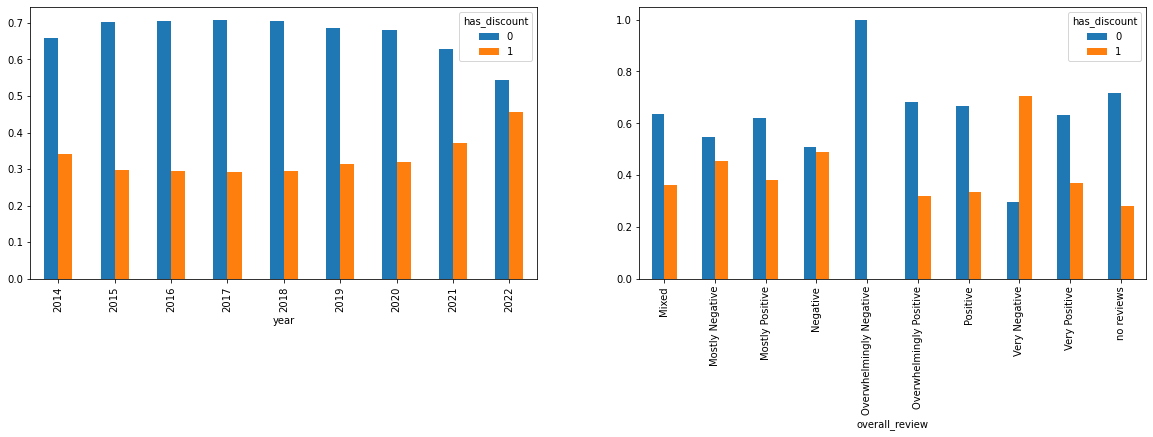

In [67]:
plot_cross_tabulation(new_df, ['year', 'overall_review'], 'has_discount', 'bar')

By investigating these graphs we can understand that there is a connection between the release year and if the game is on sale or not and also between the precentage of positve reviews.

The newer the game the possiblity for it to be on sale is higher and if it's positive reviews precentage is around 5% - 15%

##### Chi

We are investigating how strong is the connection between release year and overall_review with the has_discount column

In [68]:
ct = cross_tabulation(new_df, 'has_discount', 'year', False)
chi2_contingency(ct)

(699.0539860883983,
 1.1438772434046122e-145,
 8,
 array([[ 1322.71371857,  1961.40310486,  3192.11355066,  4774.16982797,
          6430.22873771,  6613.56859285,  8113.62195313, 10591.04341392,
          3854.13710033],
        [  661.28628143,   980.59689514,  1595.88644934,  2386.83017203,
          3214.77126229,  3306.43140715,  4056.37804687,  5294.95658608,
          1926.86289967]]))

We found that the p_value is lower then 0.05 then we can understand that there is a very strong connection between has_discount and the game's release year

In [69]:
ct = cross_tabulation(new_df, 'has_discount', 'overall_review', False)
chi2_contingency(ct)

(684.614981332536,
 1.4028430428321692e-141,
 9,
 array([[7.24025755e+03, 1.15870788e+03, 5.24752000e+03, 2.01340495e+02,
         2.66676153e+00, 6.88691165e+02, 6.26288945e+03, 3.40012095e+01,
         8.09562131e+03, 1.79213042e+04],
        [3.61974245e+03, 5.79292115e+02, 2.62348000e+03, 1.00659505e+02,
         1.33323847e+00, 3.44308835e+02, 3.13111055e+03, 1.69987905e+01,
         4.04737869e+03, 8.95969583e+03]]))

We can see here that there is also a connection between has_discount and overall_review

#### Correlation between a categorial variable and a numberic continuous variable

We've learned about the affects of release year and positive reviews of whether the game is on sale or not. Let's investigate the correlation between those parameters with the precantage of the discount.

year
2014    25.018145
2015    20.617947
2016    19.500418
2017    18.397291
2018    18.108450
2019    17.859073
2020    16.741085
2021    18.628226
2022    15.762844
Name: discount, dtype: float64

<AxesSubplot:xlabel='year'>

Text(0, 0.5, 'Discount precentage')

Text(0.5, 1.0, 'Correlation between release year and the discount precentage')

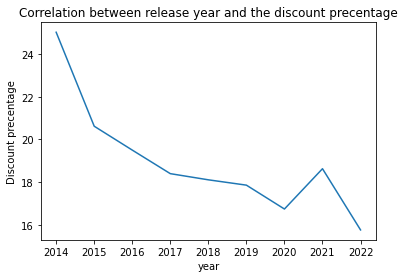

In [70]:
new_df.groupby('year').discount.mean()
new_df.groupby('year').discount.mean().plot(kind='line')
plt.ylabel('Discount precentage')
plt.title("Correlation between release year and the discount precentage")

As we can realize from this graph. The older the game the bigger the discount it might have.
But let's not forget that the older the game, the porobability to have a discount is lower.

##### histogram

<AxesSubplot:>

Text(0.5, 0, 'discount')

Text(0, 0.5, 'frequency')

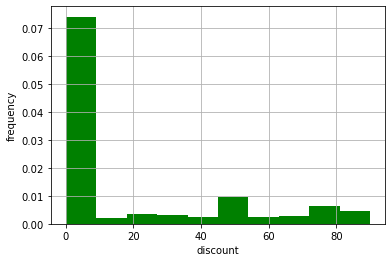

In [71]:
new_df.discount.hist(density=True, color="green")
plt.xlabel('discount')
plt.ylabel('frequency')

After investigating the histogram results we can see that our histograma is leaning toward the left. 

We are pretty satisfied with the outcomes. Looks like the frequencies of no discount is much higher but its because the game with discount has many levels of discounts and we can see clearly that the frequency of 50% discount is higher then the other discount precentages.

##### kernel density plot

We can also see the results using kernel density plot, and by comparing it to the positive review precantage it looks like this:

<AxesSubplot:xlabel='discount', ylabel='Density'>

Text(0.5, 0, 'discount & positive review precentage')

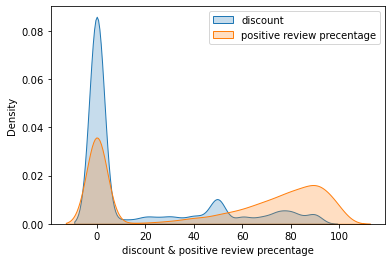

In [72]:
ax = sns.kdeplot(new_df.discount, shade=True)
sns.kdeplot(new_df.percentage_positive_total_reviewed, shade=True)

ax.set_xlabel("discount & positive review precentage")
plt.legend(title="", labels=['discount','positive review precentage'])

From the results shown here, we can see clearly that there is some connection between the discount and the positive review.
We can see that when there is no discount, the positive reviews are higher.

##### box plot

C:\Users\maypo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='year', ylabel='discount'>

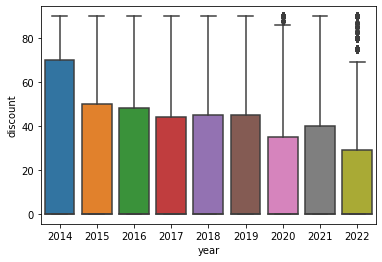

In [73]:
sns.boxplot(new_df.year, new_df.discount)

Looks like in 2022 we have some outliers which represents that there are some high discount precentage values compared to the avarage discunt during 2022. We can also learn that the high discounts can be found in games that were released during 2014.

##### violin plot

Let's combine the box plot with the kerenl density plot to one violin plot:

C:\Users\maypo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='year', ylabel='discount'>

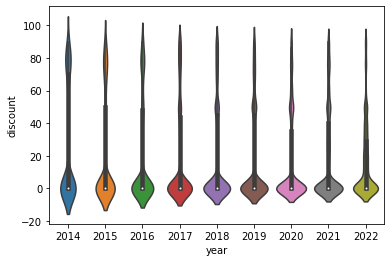

In [74]:
sns.violinplot(new_df.year, new_df.discount)

##### line plot

Here we can see the avarages of both discount and positve reviews in one line plot ordered by release year.

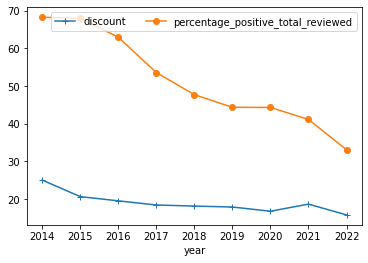

In [75]:
plot_df = new_df.groupby(['year']).mean()[['discount', 'percentage_positive_total_reviewed']]
plot_df.plot(style=['+-','o-']).legend(ncol=2)

#### Correlation between two numberic continuous variables

percentage_positive_total_reviewed
0      15.144180
3       0.000000
4       0.000000
5      56.000000
6       0.000000
         ...    
96     12.906122
97     15.462939
98      7.789617
99     14.513889
100    15.672799
Name: discount, Length: 99, dtype: float64

<AxesSubplot:xlabel='percentage_positive_total_reviewed'>

Text(0, 0.5, 'Discount precentage')

Text(0.5, 1.0, 'Correlation between positive reviews and the discount precentage')

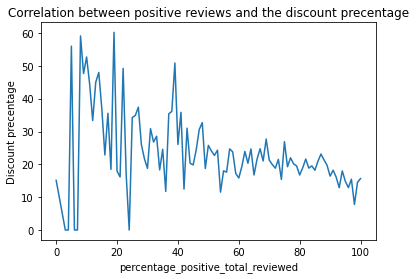

In [76]:
new_df.groupby('percentage_positive_total_reviewed').discount.mean()
new_df.groupby('percentage_positive_total_reviewed').discount.mean().plot(kind='line')  #kind=line is used in order to obtain a line plot\n",
plt.ylabel('Discount precentage')
plt.title("Correlation between positive reviews and the discount precentage")

This graph represents that when the positive reviews are around 5-20% the bigger the discount.
It's a bit similar to the graph above that represents that the chanses to have a discount are higher when the positive reviews are between 5-15%.

#### Multi dimantional visualizations

<AxesSubplot:xlabel='price', ylabel='percentage_positive_total_reviewed'>

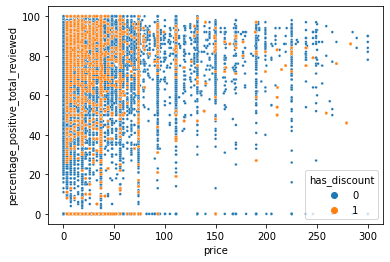

In [77]:
sns.scatterplot(x = 'price', y = 'percentage_positive_total_reviewed', s=7, hue='has_discount', data=new_df)

By investigating this graph, we can understand that when the price is low and the positive reviews are high then its more likely that the game has a discount.

Text(0.5, 0, 'positive reviews')

Text(0.5, 0, 'price')

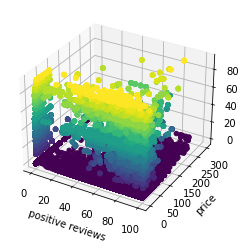

In [78]:
ax = plt.axes(projection="3d")
xdata = new_df.percentage_positive_total_reviewed
ydata = new_df.price
zdata = new_df.discount

plt.xlabel('positive reviews')
plt.ylabel('price')

ax.scatter3D(xdata, ydata, zdata, c=zdata, depthshade=False)

Similar to the previouse graph, when the price is low and the positive reviews are high the higher the discount.

### Summarizing the results

1. It's more likely to have a discount on new games then on older games.
2. The later the release date the lower the discount precentage.
3. When the price is low and the positve reviews are hight then it's more likely to have a discount and the discount precentage will be higher.
4. There is a connection between the release year and the overall reviews with whether the game has a discount or not.

Our data is balanced and we could find connections between the different paramers with the discount variable.
We can now prepare our data for the machine learning model.

### _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _

## Data preparation

In [79]:
def factorize_column(col_name, dataset):
    return pd.factorize(dataset[col_name], sort=True)[0]

##### Title & Overall revirew - factorize

In [80]:
num_dataset = new_df.copy()
num_dataset['title'] = factorize_column('title', num_dataset)
num_dataset['overall_review'] = factorize_column('overall_review', num_dataset)

We no longer need the 'has_discount' and the 'price_discount' columns. Let's remove it:

In [81]:
def drop_unused_parameters(df, parameters):
    return df.drop(parameters, axis=1).copy()

In [82]:
#num_dataset = drop_unused_parameters(num_dataset, ['has_discount', 'discount'])

In [83]:
#num_dataset = drop_unused_parameters(num_dataset, ['has_discount', 'price_discount'])

In [84]:
#num_dataset = drop_unused_parameters(num_dataset, ['discount', 'price_discount'])

### _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _

## Model

#### helper functions

Split data to base and target

In [85]:
def split_base_traget(df, target_col):
    return df.drop(target_col, axis=1), df[target_col]

Split dataset to train and test

In [86]:
def split_to_train_and_test(dataset, label_column, test_ratio, rand_state):
    X, y = split_base_traget(dataset, label_column)
    return train_test_split(X, y, random_state=rand_state, test_size=test_ratio)

Returns the prdicted y values

In [87]:
def predict_model(trained_model, X_test):
    return trained_model.predict(X_test)

##### Scaling functions

In [88]:
def scale_dataset(scaler, df):
    return pd.DataFrame(scaler.fit_transform(df.values), columns=df.columns, index=df.index)

In [89]:
def run_standard_scaler(df):
    scaler = StandardScaler()
    return scale_dataset(scaler, df)

Run MinMax scaler

In [90]:
def run_min_max_scaler(df):
    scaler = MinMaxScaler()
    return scale_dataset(scaler, df)

##### Logistical Regrassion functions

Train the model using Logistical regression

In [91]:
def train_model_logistic(X_train, y_train):
    reg = linear_model.LogisticRegression()
    return reg.fit(X_train,y_train)

Run f1 to evaluate the model performance

In [92]:
def evaluate_performance_f1(y_test, y_predicted):
    return metrics.f1_score(y_test, y_predicted)

Return all the games with discount from a given dataset

In [93]:
def get_games_with_discount(df):
    return num_dataset[df.has_discount == 1]

##### Linear Regrassion functions

Train the model using Linear regression

In [94]:
def train_model_linear(X_train, y_train):
    reg = linear_model.LinearRegression()
    return reg.fit(X_train, y_train)

Run r2 score to evaluate the model performance

In [95]:
def evaluate_performance_r2(y_test, y_predicted):
    return metrics.r2_score(y_test, y_predicted)

#### Set Parameters

In [96]:
test_ratio, rand_state = 0.2, 20

### Logistical Regrassion Model

Predict which of the games will have a discount

#### Prepare the dataset

In [122]:
has_discount_dataset = drop_unused_parameters(num_dataset, ['discount', 'price_discount'])

Scaling the model

In [123]:
scaled_df = run_min_max_scaler(has_discount_dataset)
scaled_df.head()

,title,win_support,mac_support,linux_support,vr_only,vr_supported,price,overall_review,percentage_positive_total_reviewed,total_reviewed,day,month,year,has_discount
0,0.051670,1.0,0.0,0.0,0.0,0.0,0.000000,0.888889,0.86,0.217799,0.100000,0.909091,0.750,0.0
1,0.256448,1.0,0.0,0.0,0.0,0.0,0.830138,0.888889,0.89,0.169661,0.766667,0.090909,1.000,0.0
2,0.447728,1.0,0.0,0.0,0.0,0.0,0.663444,0.888889,0.94,0.007847,0.133333,0.272727,1.000,0.0
3,0.587098,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.56,1.000000,0.666667,1.000000,0.375,0.0
4,0.540700,1.0,0.0,0.0,0.0,0.0,0.366561,0.888889,0.80,0.043832,0.333333,0.636364,0.875,0.0


#### Training the model 

In [124]:
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = split_to_train_and_test(scaled_df, 'has_discount', test_ratio, rand_state)

In [125]:
trained_model_scaled = train_model_logistic(X_train_scaled, y_train_scaled)

Classifiers:

In [102]:
def perform_classifiers(X_train, X_test, y_train, y_test):
    clf1 = tree.DecisionTreeClassifier()
    clf2 = RandomForestClassifier()
    clf3 = GaussianNB()
    clf4 = KNeighborsClassifier()
    
    alg_names = ["DecisionTree", "RandomForest", "NayievBase", "KNN"]
    
    for indx, clf in enumerate([clf1, clf2, clf3, clf4]):
        clf.fit(X_train, y_train)
        
        y_pred = clf.predict(X_test)
        y_pred_train = clf.predict(X_train)
        
        print(f"-----------{alg_names[indx]}-----------")
        print(f"accuracy on train is {metrics.accuracy_score(y_true=y_train, y_pred= y_pred_train)}")
        print(f"accuracy on test is {metrics.accuracy_score(y_true=y_test, y_pred= y_pred)}")
        print(f"confusion matrix")
        print(metrics.confusion_matrix(y_test, y_pred))

In [103]:
perform_classifiers(X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled)

-----------DecisionTree-----------
accuracy on train is 1.0
accuracy on test is 0.9600170745589073
confusion matrix
[[8836  561]
 [   1 4658]]
-----------RandomForest-----------
accuracy on train is 1.0
accuracy on test is 0.9960870802504269
confusion matrix
[[9343   54]
 [   1 4658]]
-----------NayievBase-----------
accuracy on train is 0.3406912007968553
accuracy on test is 0.33800512236767216
confusion matrix
[[ 122 9275]
 [  30 4629]]
-----------KNN-----------
accuracy on train is 0.9196919300617207
accuracy on test is 0.8794109277177006
confusion matrix
[[7785 1612]
 [  83 4576]]


After investigating the different classifiers, it seems like the Random Forest was the most accurate.
But we also performed over sampling and this might be the reason.
Same as Decision tree. Let's use KNN for predicting our data

In [104]:
clf = KNeighborsClassifier()
clf.fit(X_train_scaled, y_train_scaled)

y_pred = clf.predict(X_test_scaled)

KNeighborsClassifier()

In [105]:
eval_res_scaled = evaluate_performance_f1(y_test_scaled, y_pred)
print(f"accuracy on test is {metrics.accuracy_score(y_true=y_test_scaled, y_pred= y_pred)}")
metrics.confusion_matrix(y_test_scaled, y_pred)
eval_res_scaled

accuracy on test is 0.8794109277177006


array([[7785, 1612],
       [  83, 4576]], dtype=int64)

0.8437355950954182

In [106]:
res_df = pd.DataFrame({"true" : y_test_scaled, "pred" : y_pred})
fails = res_df[res_df.true != res_df.pred]
fails

,true,pred
40844,0.0,1.0
5066,0.0,1.0
62022,1.0,0.0
33071,0.0,1.0
22570,0.0,1.0
...,...,...
30675,0.0,1.0
22919,0.0,1.0
19005,0.0,1.0
17378,0.0,1.0


Not bad... Let's try to find the best hyper parameter for KNN.

In [107]:
def find_best_KNN_param():
    clf = KNeighborsClassifier()
    params = {"n_neighbors":[3, 5, 10]}
    clfCV = GridSearchCV(clf, params, cv= 10)

    clfCV.fit(X_train_scaled, y_train_scaled)
    
    print(f"best params: {clfCV.best_params_}")
    print(f"best score: {clfCV.best_score_}")
    
    return clfCV.best_params_

In [108]:
# bestK = find_best_KNN_param()
# clf = KNeighborsClassifier(n_neighbors= bestK)

We've found out that 3 is the best hyper parameter and used it as our parameter in the KNN algorithm.
#### In this case, the best score is too high which might imply that we have overfitting.
This sounds like a reasonable case due to the fact that the algorithm is looking for 3 closest neighbors and we performed oversampling that duplicated some of our data.

We will use KNN with 7 neighbors.

- we are marking this as comment to avoid running it every time (it takes a lot of time)

In [109]:
clf = KNeighborsClassifier(n_neighbors= 7)
clf.fit(X_train_scaled, y_train_scaled)

KNeighborsClassifier(n_neighbors=7)

#### Predict

In [110]:
y_pred = clf.predict(X_test_scaled)

#### Evaluate

In [111]:
eval_res_scaled = evaluate_performance_f1(y_test_scaled, y_pred)
print(f"accuracy on test is {metrics.accuracy_score(y_true=y_test_scaled, y_pred= y_pred)}")
metrics.confusion_matrix(y_test_scaled, y_pred)
eval_res_scaled

accuracy on test is 0.840352874217416


array([[7410, 1987],
       [ 257, 4402]], dtype=int64)

0.7968863142650253

#### This results makes much more sense!

### Linear Regression

Let's try to predict the discount precentage for every game with discount

Prepare...

In [112]:
discount_df = get_games_with_discount(num_dataset)
discount_df = drop_unused_parameters(num_dataset, ['has_discount', 'price_discount'])

Train...

In [113]:
X_train_discount, X_test_discount, y_train_discount, y_test_discount = split_to_train_and_test(discount_df, 'discount', test_ratio, rand_state)
trained_discount_model = train_model_linear(X_train_discount, y_train_discount)

Predict...

In [114]:
y_discount_pred = trained_discount_model.predict(X_test_discount)

Evaluate...

In [115]:
eval_res_discount = evaluate_performance_r2(y_test_discount, y_discount_pred)
eval_res_discount

0.016047142359504774

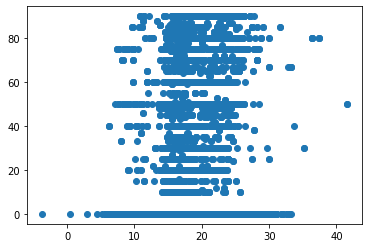

In [116]:
plt.scatter(y_discount_pred, y_test_discount)

This result is too scattered around. We can understand that we don't have enough parameters to determine the game discount value.